In [8]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
import pandas as pd

In [11]:
data = pd.read_csv('codes.csv')

In [17]:
df = data

In [5]:
codes = read_codes(filenames, 10000)

In [9]:
print(tf.config.list_physical_devices('GPU'))

[]


In [18]:
df['code_array'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]).reshape(29, 29))

In [19]:
# Function to split DFT into real and imaginary parts and reshape them
def split_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers]).reshape(29, 29)
    imag_part = np.array([c.imag for c in complex_numbers]).reshape(29, 29)
    return real_part, imag_part

# Apply the function to each row
df['dft_real'], df['dft_imag'] = zip(*df['dft'].apply(split_dft))


In [23]:
df['dft_real'][1]

array([[ 4.25000000e+02,  1.25048377e+01,  3.29551273e+00,
        -6.59940540e+00, -6.49263173e+00, -2.34222924e+00,
         3.69285228e+01, -3.95589207e+00,  9.95861026e+00,
         2.22700519e+01,  2.31678449e+01,  4.04372723e+00,
         1.51240036e+00,  1.77428351e+01,  8.96581550e+00,
         8.96581550e+00,  1.77428351e+01,  1.51240036e+00,
         4.04372723e+00,  2.31678449e+01,  2.22700519e+01,
         9.95861026e+00, -3.95589207e+00,  3.69285228e+01,
        -2.34222924e+00, -6.49263173e+00, -6.59940540e+00,
         3.29551273e+00,  1.25048377e+01],
       [ 2.28219039e+00,  2.54856613e+00,  1.52274739e+01,
         6.21621767e+00, -6.72311124e+00,  1.77439740e+01,
         1.25687709e+01, -1.68003397e+01,  1.09795270e+00,
         2.28015068e+01, -4.09725879e-01,  5.53218998e+00,
         4.26240223e+00,  9.91589158e+00,  7.98949928e+00,
         8.65632883e-01, -7.44096103e+00,  3.61719771e+00,
        -7.24088667e+00,  8.65895996e+00, -6.28216870e+00,
        -1.51

In [59]:
def split_data(data, train_percentage, seed=None):
    # Set the random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # Shuffle the data
    shuffled_indices = np.random.permutation(len(data))
    data = data[shuffled_indices]
    
    # Calculate the split index
    train_size = int(len(data) * train_percentage)
    
    # Split the data into training and testing sets
    train_set = data[:train_size]
    test_set = data[train_size:]
    
    return train_set, test_set

In [63]:
X_tr, X_te = split_data(dfts, 0.8, 12345)
y_tr, y_te = split_data(codes, 0.8, 12345)

In [64]:
def initialize_model(N):
    model = Sequential([
        Input(shape=(1682,)),     # 1682 input features
        Dense(841, use_bias=False) # 841 output features
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [65]:
model = initialize_model(841)

In [71]:
model.fit(X_tr, y_tr, epochs = 50, batch_size = 20)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2386
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0372
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8393
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8446
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0716
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8493
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5371
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2865
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2342
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3162
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1485
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0960
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0944
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7477
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3015
Epoch 16/50
40/40 ━

In [80]:
def predictions(x):
    pred = model.predict(x)[0]
    return pred




In [82]:
result = predictions(X_te)
print(f'ANN matches FFT: {np.allclose(result, y_te)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
ANN matches FFT: False


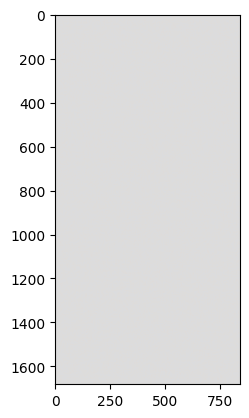

In [90]:
# Heat map of neuron weights
plt.imshow(model.get_weights()[0], vmin=-1, vmax=1, cmap='coolwarm')

In [91]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
